# Figure 3 notebook - this focuses on severe

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import evaluate, calc, cases, defaults, inputs, metrics, regions, derived

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

# ugly hack to load in our plotting scripts
# import sys  # noqa: E402

#sys.path.append(basepath + "/docs/notebooks/")
import src.plots.paper_plotting as pp  # noqa: E402


In [3]:

# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()

# downselect to only the severe cases
ewb_cases = ewb_cases.select_cases("event_type", "severe_convection")

# build out all of the expected data to evalate the case (we need this so we can plot
# the LSR reports)
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [4]:

# to plot the targets, we need to run the pipeline for each case and target
from joblib import Parallel, delayed  # noqa: E402
from joblib.externals.loky import get_reusable_executor  # noqa: E402

# load in all the case info (note this takes awhile in non-parallel form as it has to
# run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

print("running the pipeline for each case and target")
parallel = Parallel(n_jobs=32, return_as="generator", backend="loky")
case_operators_with_targets_established_generator = parallel(
    delayed(
        lambda co: (
            co.case_metadata.case_id_number,
            evaluate.run_pipeline(co.case_metadata, co.target),
        )
    )(case_operator)
    for case_operator in case_operators
)
case_operators_with_targets_established = list(
    case_operators_with_targets_established_generator
)
# this will throw a bunch of errors below but they're not consequential. this releases
# the memory as it shuts down the workers
get_reusable_executor().shutdown(wait=True)


running the pipeline for each case and target


In [ ]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

severe_tp_settings = {'linestyle':'-', 'marker':'o', 'group':'True Positives'}
severe_fn_settings = {'linestyle':'--', 'marker':'x', 'group':'False Negatives'}


In [6]:
# load the results back in
# fourv2_severe_results = pd.read_pickle(basepath + 'saved_data/fourv2_severe_results.pkl')
pang_severe_results = pd.read_pickle(basepath + 'saved_data/pang_severe_results.pkl')
hres_severe_results = pd.read_pickle(basepath + 'saved_data/hres_severe_results.pkl')
gc_severe_results = pd.read_pickle(basepath + 'saved_data/gc_severe_results.pkl')


In [7]:
fourv2_gfs_era5_settings_tp = fourv2_gfs_cira_settings | fourv2_style | severe_tp_settings 
gc_gfs_era5_settings_tp  = gc_gfs_cira_settings | gc_style | severe_tp_settings 
pangu_gfs_era5_settings_tp = pangu_gfs_cira_settings | pangu_style | severe_tp_settings 
hres_era5_settings_tp = hres_ifs_settings | hres_style | severe_tp_settings 

# grab the severe results
# fourv2_severe_plot_tp = pp.subset_results_to_xarray(results_df=fourv2_severe_results, 
#     forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
#     target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
gc_severe_plot_tp = pp.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
pangu_severe_plot_tp  = pp.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
hres_severe_plot_tp = pp.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')

# plot the results
severe_data_tp = [gc_severe_plot_tp, pangu_severe_plot_tp, hres_severe_plot_tp]
severe_settings_tp = [gc_gfs_era5_settings_tp, 
    pangu_gfs_era5_settings_tp, hres_era5_settings_tp]


fourv2_gfs_era5_settings_fn = fourv2_gfs_cira_settings | fourv2_style | severe_fn_settings 
gc_gfs_era5_settings_fn  = gc_gfs_cira_settings | gc_style | severe_fn_settings 
pangu_gfs_era5_settings_fn = pangu_gfs_cira_settings | pangu_style | severe_fn_settings 
hres_era5_settings_fn = hres_ifs_settings | hres_style | severe_fn_settings 
print(gc_gfs_era5_settings_fn)

# grab the results for the false negatives
# fourv2_severe_plot_fn = pp.subset_results_to_xarray(results_df=fourv2_severe_results, 
#     forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
#     target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
gc_severe_plot_fn = pp.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
pangu_severe_plot_fn = pp.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
hres_severe_plot_fn = pp.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')

# plot the results
severe_data_fn = [gc_severe_plot_fn, pangu_severe_plot_fn, hres_severe_plot_fn]
severe_settings_fn = [gc_gfs_era5_settings_fn, 
    pangu_gfs_era5_settings_fn, hres_era5_settings_fn]

{'forecast_source': 'CIRA GC GFS', 'label_str': 'GraphCast', 'color': '#A15A7E', 'linestyle': '--', 'marker': 'x', 'group': 'False Negatives'}


In [8]:
# make the bounding boxes for the regions

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = pp.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = pp.get_polygon_from_bounding_box(au_bounding_box)
au_bounding_region = regions.BoundingBoxRegion(latitude_min=-50, latitude_max=-10, longitude_min=110, longitude_max=180)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
au_subset = regions.RegionSubsetter(region=au_bounding_region, method='intersects').subset_case_collection(ewb_cases)

na_case_ids = [n.case_id_number for n in na_subset.cases]
au_case_ids = [n.case_id_number for n in au_subset.cases]

print(f'North America Cases: {na_case_ids}')
print(f'Australia Cases: {au_case_ids}')


North America Cases: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339]
Australia Cases: [259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281]


In [19]:
case_operators_with_targets_established

[(36,
  <xarray.Dataset> Size: 237kB
  Dimensions:                       (valid_time: 2, latitude: 82, longitude: 179)
  Coordinates:
    * valid_time                    (valid_time) datetime64[ns] 16B 2024-07-13T...
    * latitude                      (latitude) float64 656B 38.25 38.5 ... 58.5
    * longitude                     (longitude) float64 1kB 241.0 241.2 ... 285.5
  Data variables:
      practically_perfect_hindcast  (valid_time, latitude, longitude) float64 235kB dask.array<chunksize=(2, 45, 179), meta=np.ndarray>
  Attributes:
      source:   practically_perfect_hindcast),
 (36,
  <xarray.Dataset> Size: 6kB
  Dimensions:      (valid_time: 1, latitude: 186, longitude: 219)
  Coordinates:
    * valid_time   (valid_time) datetime64[ns] 8B 2024-07-13T12:00:00
    * latitude     (latitude) float64 1kB 38.38 38.4 38.52 ... 53.13 53.37 53.56
    * longitude    (longitude) float64 2kB 244.5 244.5 244.6 ... 271.8 274.4 280.1
  Data variables:
      report_type  (valid_time, latitu

In [22]:
np.unique(case_operators_with_targets_established[3][1].report_type.data.todense())


array([ 1., nan])

[<xarray.Dataset> Size: 6kB
Dimensions:      (valid_time: 1, latitude: 186, longitude: 219)
Coordinates:
  * valid_time   (valid_time) datetime64[ns] 8B 2024-07-13T12:00:00
  * latitude     (latitude) float64 1kB 38.38 38.4 38.52 ... 53.13 53.37 53.56
  * longitude    (longitude) float64 2kB 244.5 244.5 244.6 ... 271.8 274.4 280.1
Data variables:
    report_type  (valid_time, latitude, longitude) float64 3kB <COO: nnz=231, fill_value=nan>
Attributes:
    report_type_mapping:  {'wind': 1, 'hail': 2, 'tor': 3}
    source:               local_storm_reports]
<xarray.DataArray 'report_type' (stacked: 231)> Size: 2kB
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
      

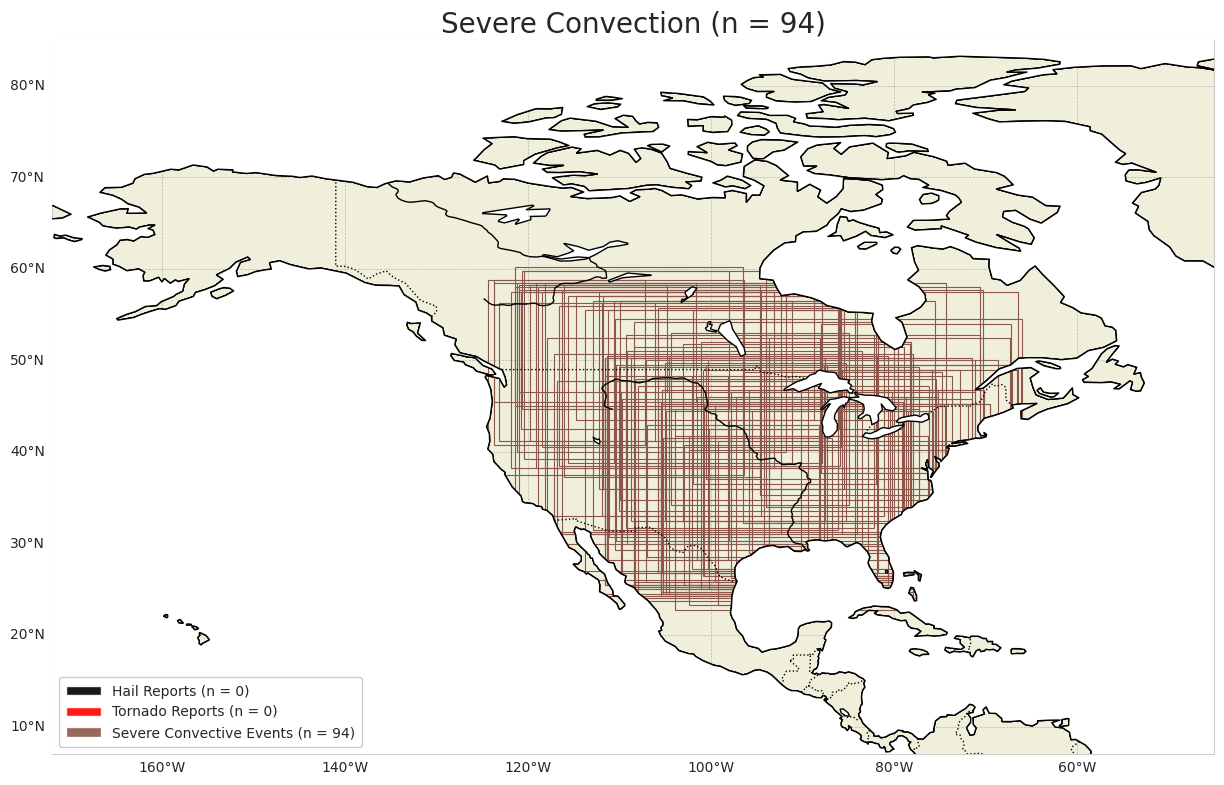

In [18]:
pp.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    bounding_box=na_bounding_box,
)


In [43]:
from re import A


def get_mean(results_df, forecast_source, target_source, metric, init_time, lead_times, case_ids=None):
    subset = pp.subset_results_to_xarray(results_df=results_df, forecast_source=forecast_source, target_source=target_source, metric=metric, init_time=init_time, case_id_list=case_ids)
    subset = subset.sel(lead_time=lead_times)
    return subset["value"].mean(dim='case_id_number').values

def get_relative_error(results_df, hres_results, forecast_source, target_source, metric, init_time, lead_time_days, case_ids=None):
    # down-select to just a few lead-times
    lead_times = [np.timedelta64(lead_time_days[i], "D") for i in range(len(lead_time_days))]
    my_mean = get_mean(results_df, forecast_source, target_source, metric, init_time, lead_times, case_ids)
    hres_mean = get_mean(hres_results, hres_ifs_settings['forecast_source'], target_source, metric, init_time, lead_times, case_ids)
    my_relative_error = (my_mean - hres_mean) / hres_mean * 100
    
    return (my_mean, my_relative_error)

def get_error_array_for_heatmap(results_array, hres_results, forecast_sources, target_source, metric_strs, init_time, lead_time_days):
    """
    This function takes in an array of results and parameters to say which results to grab and returns 
    error arrays and relative arrays for global, north america, and europe.
    """
    # now make the array for the scorecard
    global_rel_error = {}
    global_error = {}

    na_rel_error = {}
    na_error = {}

    au_rel_error = {}
    au_error = {}


    for metric in metric_strs:
        # initialize the arrays
        global_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        global_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        na_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        na_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        au_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        au_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        for i, results_df in enumerate(results_array):
            my_mean, my_relative_error = get_relative_error(results_df, hres_results, forecast_sources[i], target_source, metric, init_time, lead_time_days)
            global_error[metric][i, :] = my_mean
            global_rel_error[metric][i, :] = my_relative_error

            na_mean, na_relative_error = get_relative_error(results_df, hres_results, forecast_source[i], target_source, metric, init_time, lead_time_days, case_ids=na_case_ids)
            na_error[metric][i, :] = na_mean
            na_rel_error[metric][i, :] = na_relative_error

            au_mean, au_relative_error = get_relative_error(results_df, hres_results, forecast_sources[i], target_source, metric, init_time, lead_time_days, case_ids=au_case_ids)
            au_error[metric][i, :] = au_mean
            au_rel_error[metric][i, :] = au_relative_error


    return global_error, global_rel_error, na_error, na_rel_error, au_error, au_rel_error

# setup for the scorecard
# Grab means for each metric for each model
severe_metric_str = ['CriticalSuccessIndex', 'FalseAlarmRatio', 'EarlySignal']
severe_display_str = ['Critical Success Index', 'False Alarm Ratio', 'Early Signal']
target_source = 'practically_perfect_hindcast'

lead_time_days = [1, 3, 5, 7, 10]

severe_results_array = [hres_severe_results, gc_severe_results, pang_severe_results]
forecast_source = [hres_ifs_settings['forecast_source'], gc_gfs_cira_settings['forecast_source'], pangu_gfs_cira_settings['forecast_source']]

(global_severe_error, global_rel_severe_error, na_severe_error, na_rel_severe_error, au_severe_error, au_rel_severe_error) = \
    get_error_array_for_heatmap(severe_results_array, hres_severe_results, forecast_source, target_source, severe_metric_str, 'zeroz', lead_time_days)

/tmp/ipykernel_188801/3193569326.py:14: RuntimeWarning: invalid value encountered in divide
  my_relative_error = (my_mean - hres_mean) / hres_mean * 100
/tmp/ipykernel_188801/3193569326.py:14: RuntimeWarning: invalid value encountered in divide
  my_relative_error = (my_mean - hres_mean) / hres_mean * 100
/tmp/ipykernel_188801/3193569326.py:14: RuntimeWarning: invalid value encountered in divide
  my_relative_error = (my_mean - hres_mean) / hres_mean * 100


(30, 36)
plotting the cases for each event type


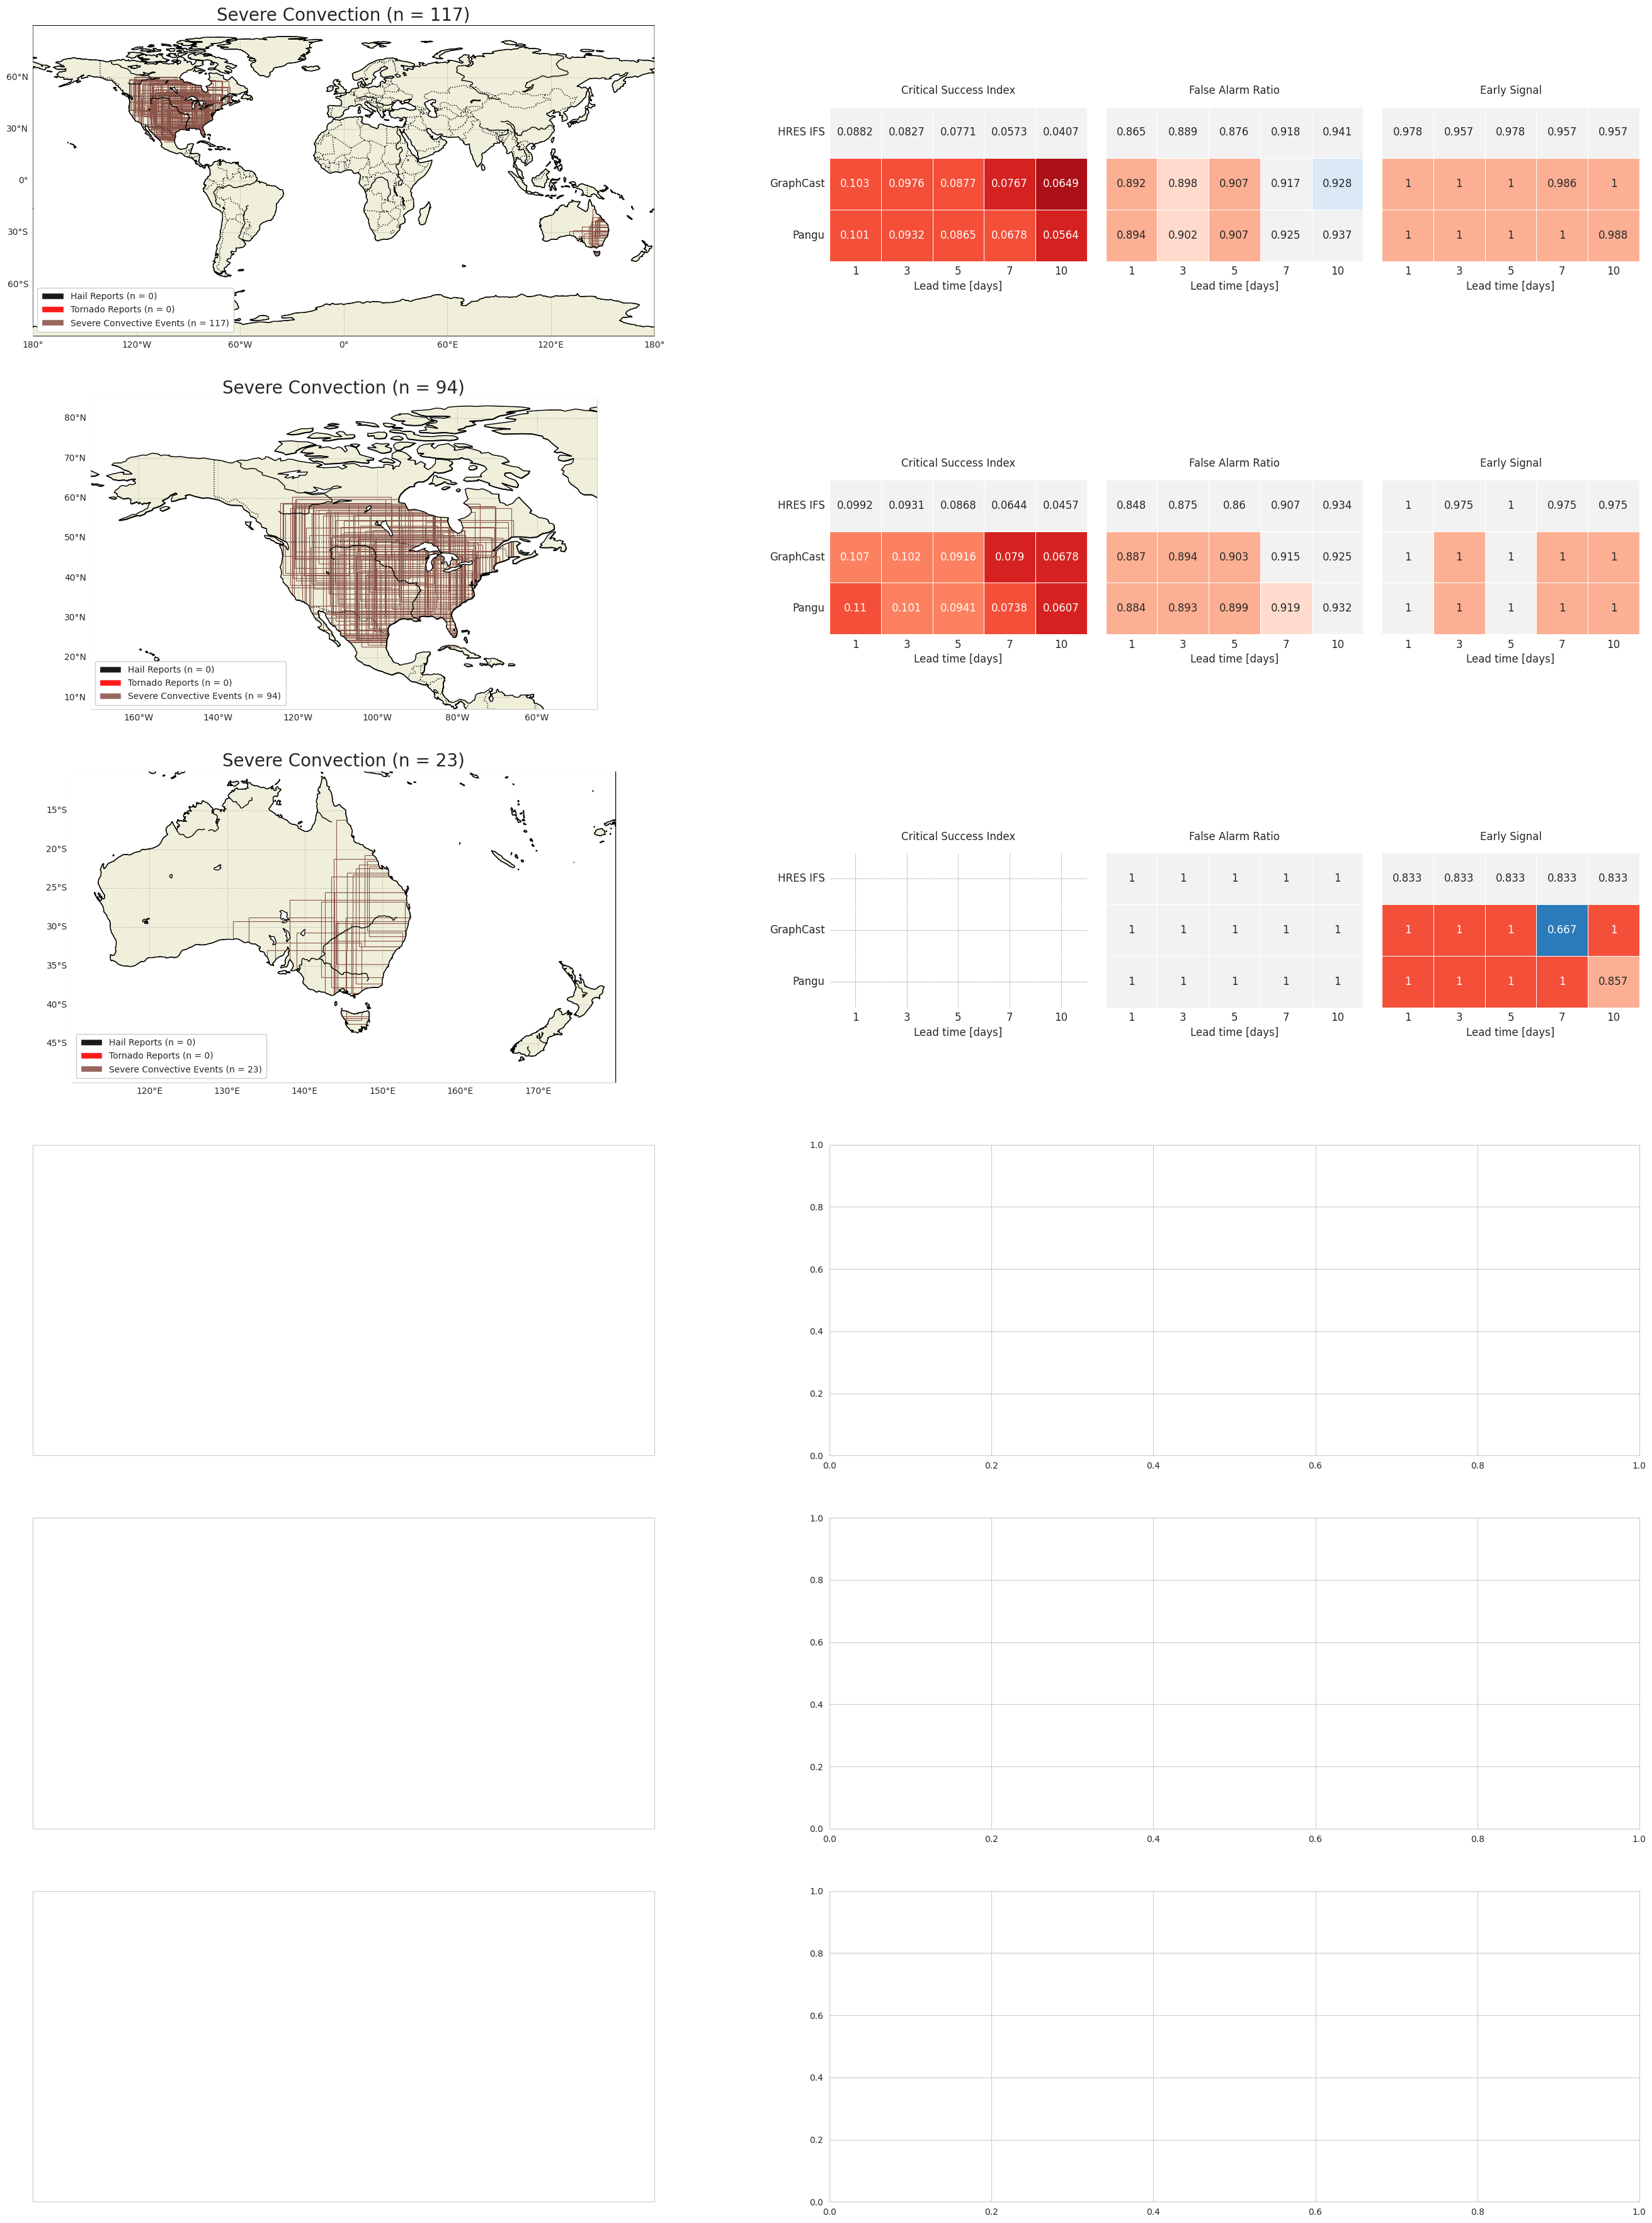

In [48]:
from matplotlib.gridspec import GridSpec

n_rows = 6
n_cols = 2
figsize = (15 * n_cols, 6 * n_rows)
print(figsize)

# Create figure first
fig = plt.figure(figsize=figsize)

# Use GridSpec for better control over subplot sizes, especially with mixed cartopy/regular subplots
# Make column 2 wider for line plots (width_ratios: col0, col1, col2)
# Use negative hspace to compress vertical spacing (negative values allow overlap)
gs = GridSpec(n_rows, n_cols, figure=fig, 
              left=0.05, right=0.95, top=0.98, bottom=0.02,
              wspace=0.1, hspace=0.2,  
              width_ratios=[1, 1])  # Make column 2 (index 2) 1.5x wider

# Create a grid of subplots - specify which ones should use cartopy
# Example: cartopy_subplots = [(0, 0), (1, 0)] means rows 0,1 in column 0 use cartopy
# You can modify this list to specify which subplots need cartopy projections
cartopy_subplots = [(0,0), (1,0), (2,0), (3,0), (4,0), (5,0)]  # Add tuples like (row, col) for subplots that need cartopy

# Create all subplots
axs = []
for i in range(n_rows):
    row = []
    for j in range(n_cols):
        if (i, j) in cartopy_subplots:
            # Create cartopy subplot
            ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree())
        else:
            # Create regular matplotlib subplot
            ax = fig.add_subplot(gs[i, j])
        row.append(ax)
    axs.append(row)

# Convert to numpy array for easier indexing (matching plt.subplots behavior)
axs = np.array(axs)

# the left hand column of figure one shows all of the cases for each event type
# plot the cases for each event type
print("plotting the cases for each event type")
pp.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    ax=axs[0, 0],
)
# plot the cases for north america
pp.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    bounding_box=na_bounding_box,
    ax=axs[1, 0],
)

# plot the cases for australia
pp.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    bounding_box=au_bounding_box,
    ax=axs[2, 0],
)


severe_settings = {}
severe_settings["subplot_titles"] = severe_display_str
severe_settings["metric_str"] = severe_metric_str
severe_settings["lead_time_days"] = lead_time_days
severe_settings["model_order"] = ["HRES IFS", "GraphCast", "Pangu"]

# second column of figure 2 shows the scorecard
pp.plot_heatmap(
    global_rel_severe_error,
    global_severe_error,
    severe_settings,
    ax=axs[0, 1],
)

pp.plot_heatmap(
    na_rel_severe_error,
    na_severe_error,
    severe_settings,
    ax=axs[1, 1],
)

pp.plot_heatmap(
    au_rel_severe_error,
    au_severe_error,
    severe_settings,
    ax=axs[2, 1],)
